# Latent semantic analysis

Create term-document matrix $A$, make SVD $A=USV^T$, use projections of #A# columns on first $n$ columns of $U$ as document vectors. Classify documents with logistic regression on these vectors. One can also consider $A$ rows projections on columns of $V$, i.e. $A\cdot V$, as word vectors.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression

import json

import winsound

In [2]:
# Load direct and inverted indices
import sys
if '..' not in sys.path:
    sys.path.append('..')
from src.utils import LoadIndices, LoadDatasets, TrainTestIdx

# Load datasets
an_jokes, bash_jokes = LoadDatasets()
# Load direct and inverted indices
an_direct, an_inverted, bash_direct, bash_inverted = LoadIndices()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Term-document matrices

There several ways to create term-document matrix. It can be binary matrix or matrix with number of word use. We can also apply different mormalizations, add regularizers, take log and so on.

In [3]:
def num_of_use(word, inverted_index):
    return len(inverted_index[word][0] + inverted_index[word][1])

def word_to_index(inverted_index):
    # List of words which are used in more than 1 joke
    i2w = [w for w in inverted_index if num_of_use(w, inverted_index) > 1]
    # Word to index map
    w2i = {w: i for i, w in enumerate(i2w)}
    return i2w, w2i
    
def term_document_1(direct_index, inverted_index, mean_sub = False):
    """Binary matrix"""
    i2w, w2i = word_to_index(inverted_index)
    num_of_words = len(i2w)  # Number of words which are used in more than 1 joke
    num_of_docs = len(direct_index)
    A = np.zeros((num_of_words, num_of_docs), dtype = np.int8)
    for j, d in enumerate(direct_index):
        for w in d:
            if w in w2i:
                i = w2i[w]
                A[i,j] = 1
    if mean_sub:
        for i in range(num_of_words):
            A[i,:] -= np.mean(A[i,:])
    return A    

def term_document_2(direct_index, inverted_index, mean_sub = False):
    """Number of word use matrix"""
    i2w, w2i = word_to_index(inverted_index)
    num_of_words = len(i2w)
    num_of_docs = len(direct_index)
    A = np.zeros((num_of_words, num_of_docs))
    for j, d in enumerate(direct_index):
        for w in d:
            if w in w2i:
                i = w2i[w]
                A[i,j] = d[w]
    if mean_sub:
        for i in range(num_of_words):
            A[i,:] -= np.mean(A[i,:])
    return A

In [4]:
def LSA_vectors(direct_index, inverted_index, dim = 50, show_singular_values = True, mean_sub = False):
    # SVD of term-document matrix
    A = term_document_1(direct_index, inverted_index, mean_sub)
    tsvd = TruncatedSVD(n_components = dim)
    tsvd.fit(A)
    # Word vectors
    US = tsvd.transform(A)
    i2w, w2i = word_to_index(inverted_index)
    word_vectors = {i2w[i] : US[i,:] for i in range(US.shape[0])}
    # Doc vectors
    s = np.zeros(dim)
    U = US.copy()
    for i in range(dim):
        s[i] = np.dot(U[:,i], U[:,i])
        U[:,i] /= s[i]
    doc_vectors = np.dot(A.T, U)

    if show_singular_values:
        plt.figure()
        plt.plot(np.log(s), '.-')
    
    return word_vectors, doc_vectors

Wall time: 4min 40s


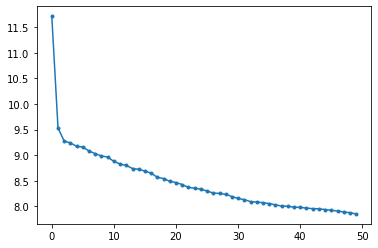

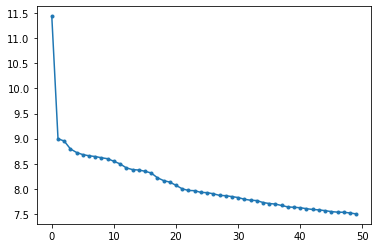

In [29]:
%%time
# ~5 min is expected

an_word_vectors, an_doc_vectors = LSA_vectors(an_direct, an_inverted, dim = 50)
bash_word_vectors, bash_doc_vectors = LSA_vectors(bash_direct, bash_inverted, dim = 50)

# Save vectors
# 1. Transform data to json serializable format
def matrix_to_list(A):
    return [list(row) for row in A]
def arrays_to_list(D):
    return {w: list(D[w]) for w in D}
data = {'anec': (arrays_to_list(an_word_vectors), matrix_to_list(an_doc_vectors)),
        'bash': (arrays_to_list(bash_word_vectors), matrix_to_list(bash_doc_vectors))
       }
# 2. save
f = open('..\\data\\interim\\trained_vectors\\lsa1.json', 'w', encoding = 'utf-8')
f.write(json.dumps(data, ensure_ascii = False))
f.close()

winsound.Beep(500, 1000)

In [5]:
# Load vectors
data = json.loads(open('..\\data\\interim\\trained_vectors\\lsa1.json', 'r', encoding = 'utf-8').read())

an_word_vectors = data['anec'][0]
an_doc_vectors = np.array(data['anec'][1])
bash_word_vectors = data['bash'][0]
bash_doc_vectors = np.array(data['bash'][1])

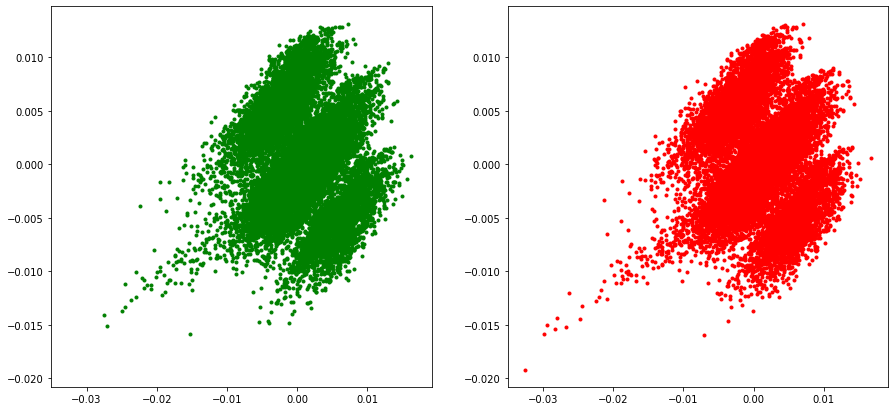

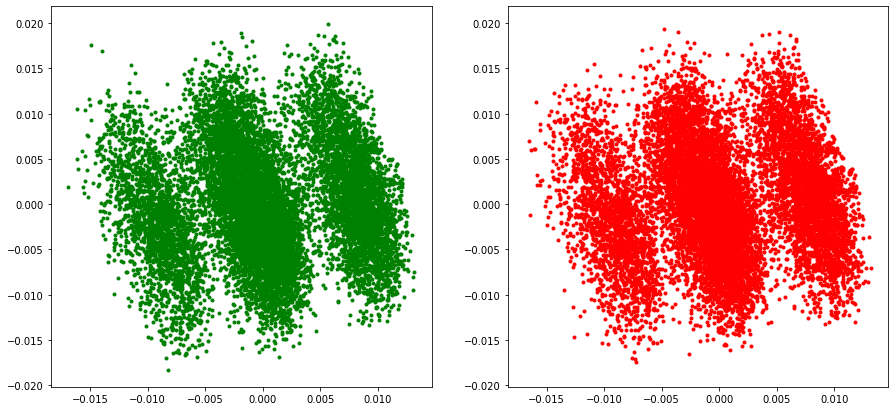

In [39]:
i1, i2 = 4, 5
is_good = np.array([d[-1] for d in an_jokes])
plt.figure(figsize = (15,7))
ax1 = plt.subplot(1,2,1)
plt.plot(an_doc_vectors[is_good == 1, i1], an_doc_vectors[is_good == 1, i2], '.', c = 'green')
plt.subplot(1,2,2, sharex = ax1, sharey = ax1)
plt.plot(an_doc_vectors[is_good == 0, i1], an_doc_vectors[is_good == 0, i2], '.', c = 'red')

is_good = np.array([d[-1] for d in bash_jokes])
plt.figure(figsize = (15,7))
ax1 = plt.subplot(1,2,1)
plt.plot(bash_doc_vectors[is_good == 1, i1], bash_doc_vectors[is_good == 1, i2], '.', c = 'green')
plt.subplot(1,2,2, sharex = ax1, sharey = ax1)
plt.plot(bash_doc_vectors[is_good == 0, i1], bash_doc_vectors[is_good == 0, i2], '.', c = 'red')

## Classification with logistic regression

In [33]:
def logistic_regression_model(jokes, doc_vectors):
    train_idx, test_idx = TrainTestIdx(jokes)
    X = doc_vectors.copy()
    y = np.array(np.array([d[-1] for d in jokes]))

    X_train = X[train_idx,:]
    y_train = y[train_idx]
    X_test = X[test_idx,:]
    y_test = y[test_idx]

    lr = LogisticRegression(penalty = 'none')
    lr.fit(X_train, y_train)
    print("Train accuracy: {:.3f}".format(lr.score(X_train, y_train)))
    print("Test accuracy: {:.3f}".format(lr.score(X_test, y_test)))
    
    return lr

def components_significance(lr_model, X):
    coef = np.squeeze(lr_model.coef_)
    dim = len(coef)
    s = np.zeros(dim)
    for i in range(dim):
        s[i] = np.dot(X[:,i],X[:,i])
    sig = np.abs(s * coef)

    print("Top 5 components:", np.argsort(sig)[::-1][:5])

    plt.plot(sig, '.-')

### Anecdotes

In [30]:
lr = logistic_regression_model(an_jokes, an_doc_vectors)

Train accuracy: 0.578
Test accuracy: 0.573


Top 5 components: [ 1  3 35 22  7]


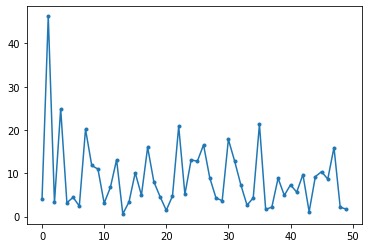

In [34]:
components_significance(lr, X)

### Bash quotes

In [36]:
lr = logistic_regression_model(bash_jokes, bash_doc_vectors)

Train accuracy: 0.580
Test accuracy: 0.577


Top 5 components: [21  3  2 18 34]


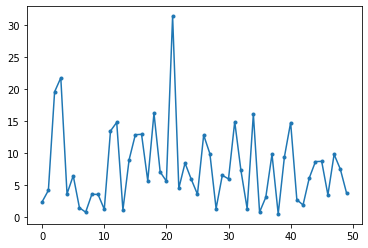

In [37]:
components_significance(lr, X)